# Imports
Imports of all the needed libraries. 
https://docs.fast.ai/

In [1]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
train_root = "/kaggle/input/100-bird-species/train"
validation_root = "/kaggle/input/100-bird-species/valid"
outroot = "/kaggle/working"

# Load the data
Loading the train data and validation data from kaggles directory

In [3]:
train_files = get_image_files(train_root)
validation_files = get_image_files(validation_root)
print("number of training files: ", len(train_files),"number of validation files: ",len(validation_files))

number of training files:  70626 number of validation files:  2250


In [4]:
from shared import label_func

In [5]:
train_dataset = ImageDataLoaders.from_path_func(outroot, train_files, label_func, item_tfms=Resize(224), batch_tfms=aug_transforms(size=224))


# Explore 

The next code block can be ran again and again to see different pictures of bird. 
By looking at different sets of pictures we can verify the quality of the pictures that goes into the model. 

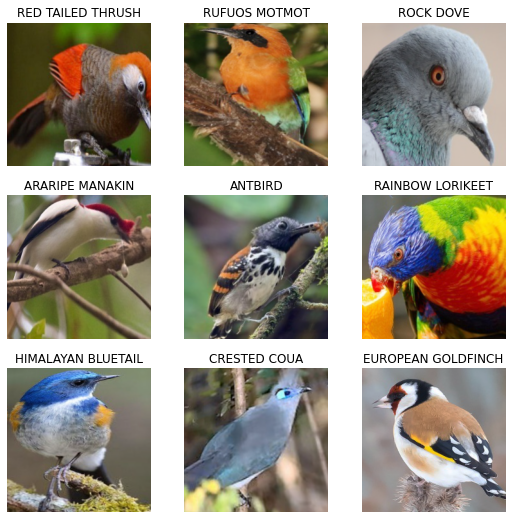

In [6]:
train_dataset.show_batch()

Here we loop through pictures to check average height and width of the pictures, as well as color channels. 

In [7]:
batch = next(iter(train_dataset))
print("received", len(batch), "batches from dataset")
avg_w = 0
avg_h = 0;
avg_channels = 0
avg_batch_size = 0
for images, labels in batch:
    avg_batch_size += images.shape[0]
    avg_channels += images.shape[1]
    avg_w += images.shape[2]
    avg_h += images.shape[3]
avg_w /= len(batch)
avg_h /= len(batch)
avg_channels /= len(batch)
avg_batch_size /= len(batch)

print("average size of an batch was",avg_batch_size,"images with dimensions(",avg_w,avg_h,") and",avg_channels,"color channels")

received 882 batches from dataset
average size of an batch was 64.0 images with dimensions( 224.0 224.0 ) and 3.0 color channels


# Training the model

In [8]:
model = vision_learner(train_dataset, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

The first thing we'll do is find the best learning rate for the model. this is defined as the point with the steepest slope.
Luckily for us, fastai has an built-in method for finding a suitably learning rate

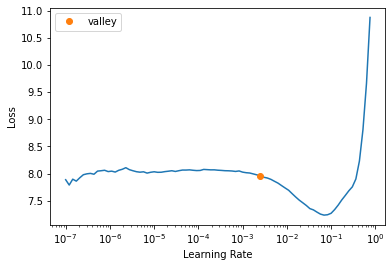

In [9]:
lr = model.lr_find()

In [10]:
print("using lr",lr.valley)

using lr 0.002511886414140463


In [11]:
print("starting training")
model.fine_tune(10,lr.valley)

starting training


epoch,train_loss,valid_loss,error_rate,time
0,1.338397,0.775775,0.198442,05:31


epoch,train_loss,valid_loss,error_rate,time
0,0.668064,0.393903,0.097062,06:00
1,0.593074,0.394478,0.104283,05:58
2,0.554887,0.390769,0.099115,06:00
3,0.412483,0.341234,0.085027,05:59
4,0.331253,0.304199,0.072850,05:58
5,0.239445,0.266221,0.063221,05:59
6,0.145952,0.235449,0.054442,06:00
7,0.092367,0.219654,0.047434,05:59
8,0.058740,0.211947,0.045947,06:00
9,0.048372,0.207086,0.044035,05:59


In [12]:
print("saving model to model2.pickle")
model.save("model2.pickle")

saving model to model2.pickle


Path('/kaggle/working/models/model2.pickle.pth')

# Verifying accuracy of the model

In [13]:
predictions = []
with model.no_bar(), model.no_logging():
    for path in validation_files:
        prediction = model.predict(path)
        predictions.append((label_func(path),prediction[0]))
print("performed", len(predictions), "predictions")

performed 2250 predictions


In [14]:
correct = 0;
wrong = 0;
for actual, predicted in predictions:
    if actual == predicted:
        correct += 1;
    else:
        wrong += 1;
print ("accuracy is ",(correct / (wrong + correct)))

accuracy is  0.9777777777777777


Here we can see that the model gets an accuracy of about 97.8% which is an pretty good score

## More analyzis
To better find out how well the model performed, we'll use the class ClassificaitonInterpretation to receive more info about the model

In [15]:
interp = ClassificationInterpretation.from_learner(model)

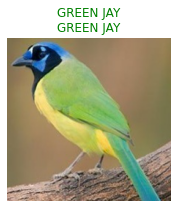

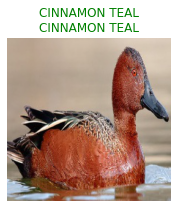

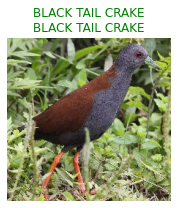

In [16]:
interp.show_results(1)
interp.show_results(2)
interp.show_results(3)

As we can see, some of the birds it guessed correctly, but we're interested in finding out which birds it didn't manage to guess correctly.
We can do that by calling plot_top_losses

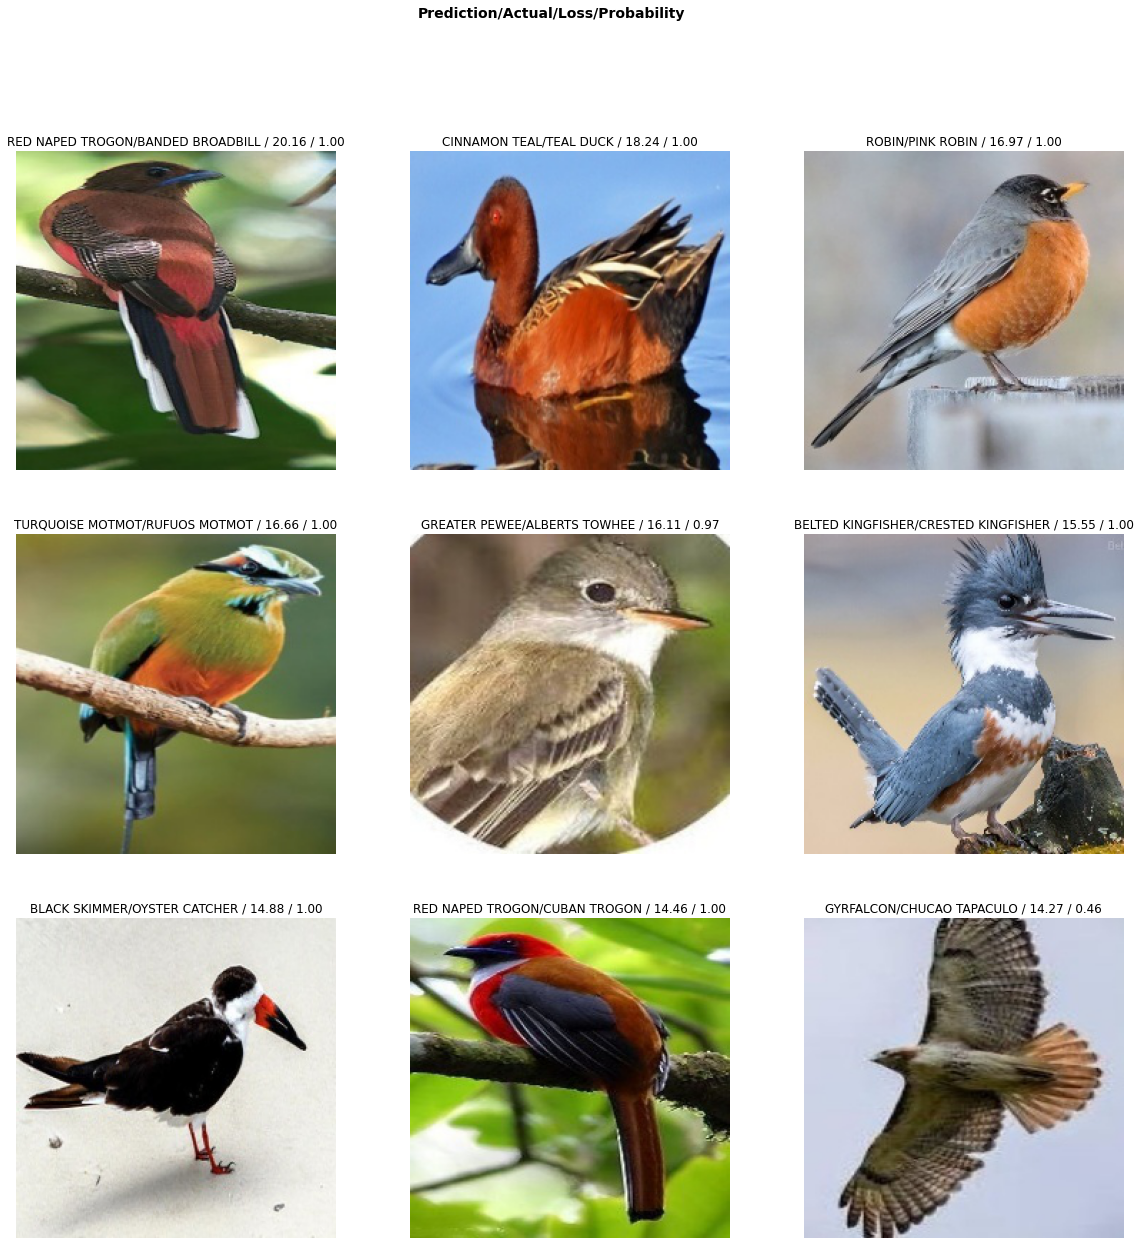

In [17]:
interp.plot_top_losses(9,figsize=(20,20))

As you can see above, some a few of the birds appear to belong to the same family of birds, like the Turqoise vs The Rufuous Motmot, this might be cause by the birds having similar appearances, with a few discerning characteristics

In [18]:
#removed due to it using way to much memory
#interp.most_confused()